<a href="https://colab.research.google.com/github/imnawar/CS681_Assinments/blob/main/Assign3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Dependencies

In [1]:
!pip install diffusers==0.29.2 transformers accelerate torch torchvision
!pip install controlnet_aux
!pip install lpips
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.2
    Uninstalling diffusers-0.35.2:
      Successfully uninstalled diffusers-0.35.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00


# 2. Import Libraries & Configure Low-VRAM Settings

In [2]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionControlNetPipeline
from diffusers import ControlNetModel
from diffusers.utils import load_image
import numpy as np
from PIL import Image
import cv2
import lpips
import math
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def show(img, title=""):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True

model_kwargs = {
    "torch_dtype": torch.float16 if DEVICE=="cuda" else torch.float32,
    "use_safetensors": True,
    "low_cpu_mem_usage": True
}

# 3. Load Stable Diffusion (Low VRAM Mode)

In [4]:
MODEL_ID = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    **model_kwargs
).to(DEVICE)

pipe.enable_attention_slicing()
pipe.enable_model_cpu_offload()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


# 4. Generate the Initial Image (Semantic Guidance Prompt)

In [23]:
prompt = (
    "A simple, cute illustration of two rounded cartoon characters standing on a plain ground "
    "under a sunny sky, soft pastel colors, minimal shapes, clean background."
)

negative_prompt = (
    "complex details, photorealism, text, watermark, dark lighting, noisy image, "
    "distorted shapes"
)

  0%|          | 0/20 [00:00<?, ?it/s]

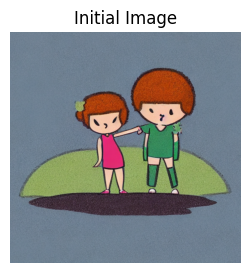

In [24]:
with torch.autocast(DEVICE):
    init = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=20,
        guidance_scale=5,
        height=512,
        width=512,
        generator=torch.Generator(DEVICE).manual_seed(123)
    ).images[0]

init.save("initial.png")
show(init, "Initial Image")


# 5. Semantic Guidance Editing (Simple Refinement)

We simulate semantic editing by prompting again with stronger emphasis on a visual detail (lavender floor).

  0%|          | 0/20 [00:00<?, ?it/s]

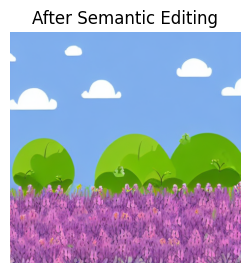

In [39]:
edit_prompt = (
    "A simple, cute illustration of two rounded cartoon characters standing on a plain ground "
    "under a sunny sky, soft pastel colors, minimal shapes, clean background. "
    "Modify the scene by changing the ground to a lavender color and improving the edge clarity "
    "while keeping the characters and sky unchanged."
)

with torch.autocast(DEVICE):
    edited = pipe(
        prompt=edit_prompt,
        negative_prompt=negative_prompt,
        image=init,
        num_inference_steps=20,
        guidance_scale=6,
        height=512,
        width=512,
        generator=torch.Generator(DEVICE).manual_seed(456)
    ).images[0]

edited.save("edited.png")
show(edited, "After Semantic Editing")


# 6. ControlNet Editing (Canny ControlNet, Low VRAM)

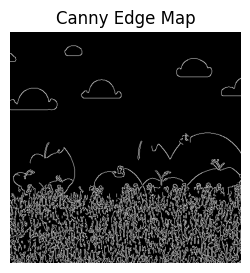

In [28]:
edited_np = np.array(edited.convert("RGB"))
gray = cv2.cvtColor(edited_np, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 80, 160)
edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
edge_img = Image.fromarray(edges)
edge_img.save("edge_map.png")
show(edge_img, "Canny Edge Map")


In [29]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    **model_kwargs
).to(DEVICE)

pipe_cn = StableDiffusionControlNetPipeline.from_pretrained(
    MODEL_ID,
    controlnet=controlnet,
    **model_kwargs
).to(DEVICE)

pipe_cn.enable_attention_slicing()
pipe_cn.enable_model_cpu_offload()


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

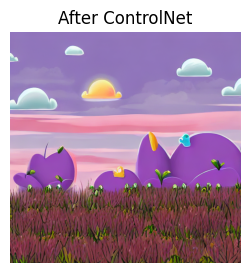

In [32]:
with torch.autocast(DEVICE):
    cn_out = pipe_cn(
        prompt=edit_prompt,
        negative_prompt=negative_prompt,
        image=edge_img,
        num_inference_steps=20,
        guidance_scale=7,
        height=512,
        width=512,
        generator=torch.Generator(DEVICE).manual_seed(789)
    )

cn_image = cn_out.images[0]
cn_image.save("controlnet_output.png")
show(cn_image, "After ControlNet")


# 7. Image Quality Metrics (LPIPS & PSNR)

In [35]:
def to_tensor(img):
    img = img.resize((512, 512))   # ensure same size
    arr = np.array(img).astype(np.float32) / 255.0
    arr = torch.tensor(arr).permute(2,0,1).unsqueeze(0)
    return arr

init_t  = to_tensor(init)
edit_t  = to_tensor(edited)
cn_t    = to_tensor(cn_image)

In [36]:
loss_fn = lpips.LPIPS(net='alex').to(DEVICE)

lpips_score = loss_fn(
    init_t.to(DEVICE),
    cn_t.to(DEVICE)
).item()

print("LPIPS Score:", lpips_score)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS Score: 0.7915377616882324


**LPIPS (Learned Perceptual Image Patch Similarity)**

Measures perceptual difference between two images.

Lower values = images are more similar to each other perceptually.

*Range: ~0 → very similar, higher values → more perceptual difference.*

**TheLPIPS Score: 0.792**

This is relatively high, which means the final ControlNet image is perceptually quite different from the initial image.

That makes sense if because the semantic editing (lavender floor, clearer outlines) introduced noticeable changes.

In [37]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnr_score = psnr(init_t, cn_t)
print("PSNR:", psnr_score)


PSNR: 11.362802174436444


**PSNR (Peak Signal-to-Noise Ratio)**

Measures pixel-level similarity.

Higher values = images are closer in raw pixel values.

*Usually ranges from 20–40 for similar images; <15 indicates significant difference.*

**The PSNR Score: 11.36**

This is very low, indicating that the final image differs strongly at the pixel level from the initial image.

This is expected because:

We performed semantic guidance edits and applied ControlNet, which enforces edge structure but allows color/texture changes. And After the editing as we can see in the shown images the init image contains charecters while the charecters are removed after editing

At low resolutions (512×512), even small edits can drastically lower PSNR.